In [100]:
import pandas as pd
import numpy as np
import graphviz

In [101]:
datapath = 'data/'
demo = pd.read_csv(datapath + 'Demographics.csv')
icd = pd.read_csv(datapath + 'ICD.csv')
lab = pd.read_csv(datapath + 'LABS.csv')
vitals = pd.read_csv(datapath + 'Vitals.csv')
inpmed = pd.read_csv(datapath + 'INP_MED.csv')
outmed = pd.read_csv(datapath + 'OUT_MED.csv')
label = pd.read_csv(datapath + 'Labels.csv')

In [102]:
demo = demo.drop_duplicates(subset = 'idx')
icd = icd.drop_duplicates(subset = 'idx')
lab = lab.drop_duplicates(subset = 'idx')
vitals = vitals.drop_duplicates(subset = 'idx')
inpmed = inpmed.drop_duplicates(subset = 'idx')
outmed = outmed.drop_duplicates(subset = 'idx')
label = label.drop_duplicates(subset = 'idx')

# Check consistency

In [103]:
print(label[label['split'] == 'val'])

      Unnamed: 0   idx  label       pe_type split
2              2  2738      0           NaN   val
11            11  2000      1       central   val
37            37   781      1       central   val
52            52   288      1  subsegmental   val
68            68   315      0           NaN   val
...          ...   ...    ...           ...   ...
1810        1810  1911      0           NaN   val
1822        1822  1425      0           NaN   val
1823        1823  1893      1     segmental   val
1829        1829   128      1       central   val
1833        1833   127      0           NaN   val

[193 rows x 5 columns]


In [104]:
print(demo[demo['idx'] == 2738])

    current_age_yrs  Female  Male  Asian  Black  Native American  Other  \
37            78.95       1     0      0      0                0      0   

    Pacific Islander  Unknown_race  White  SMOKER_N  SMOKER_Y   idx split  
37                 0             1      0         1         0  2738   val  


# Combine

In [105]:
combined_df = demo

for df in [icd, lab, vitals, label, inpmed, outmed]:
    combined_df = combined_df.merge(df, on='idx', how='outer', suffixes=('', '_duplicate'))

columns_to_drop = [col for col in combined_df.columns if '_duplicate' in col]
combined_df.drop(columns=columns_to_drop, inplace=True)

In [106]:
combined_df

,current_age_yrs,Female,Male,Asian,Black,Native American,Other,Pacific Islander,Unknown_race,White,...,Outpatient_LHRH(GNRH)AGNST PIT.SUP-CENTRAL PRECOCIOUS PUBERTY:Frequeny,Outpatient_THROMBOLYTIC - NUCLEOTIDE TYPE:Frequeny,Outpatient_SELECTIVE SEROTONIN 5-HT2A INVERSE AGONISTS (SSIA):Frequeny,Outpatient_ANTINEOPLASTIC - HEDGEHOG PATHWAY INHIBITOR:Frequeny,Outpatient_ORGAN TRANSPLANTATION PRESERVATION SOLUTIONS:Frequeny,Outpatient_FEEDING DEVICES:Frequeny,"Outpatient_DRUGS TO TX GAUCHER DX-TYPE 1, SUBSTRATE REDUCING:Frequeny","Outpatient_TOPICAL PREPARATIONS,NON-MEDICINAL:Frequeny","Outpatient_ANTI-INFLAMMATORY, INTERLEUKIN-1 BETA BLOCKERS:Frequeny","Outpatient_ACNE AGENTS,SYSTEMIC:Frequeny"
0,80.00,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,64.12,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,93.42,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,93.82,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,71.78,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1832,71.04,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1833,40.12,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1834,52.20,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1835,59.40,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [107]:
non_integer_columns = combined_df.columns[combined_df.applymap(lambda x: not isinstance(x, (int, float))).any()]
print(non_integer_columns)

Index(['split', 'pe_type'], dtype='object')


In [108]:
split_label = combined_df[['idx', 'pe_type', 'split']]


# PCA

In [109]:
pcadata = combined_df.drop(columns=['Unnamed: 0', 'pe_type', 'split', 'idx', 'label'])

In [110]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [111]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pcadata)

pca = PCA()
pca.fit(scaled_data)

# Determine the number of components for desired explained variance (e.g., 95%)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1  # Number of components to retain

# Reapply PCA with the determined number of components
pca = PCA(n_components=n_components)
pca.fit(scaled_data)

# Get the absolute values of loadings (contributions) of each feature in each component
loadings = np.abs(pca.components_)

# For each component, find the top features and then aggregate these features
top_features = set()
for i in range(loadings.shape[0]):
    sorted_idx = loadings[i, :].argsort()[::-1][:200]  # Top features for each component
    top_features.update(sorted_idx)

# Select columns of top contributing features
df_top_features = pcadata.iloc[:, list(top_features)]

In [112]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pcadata)

pca = PCA()
principal_components = pca.fit_transform(scaled_data)

In [113]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

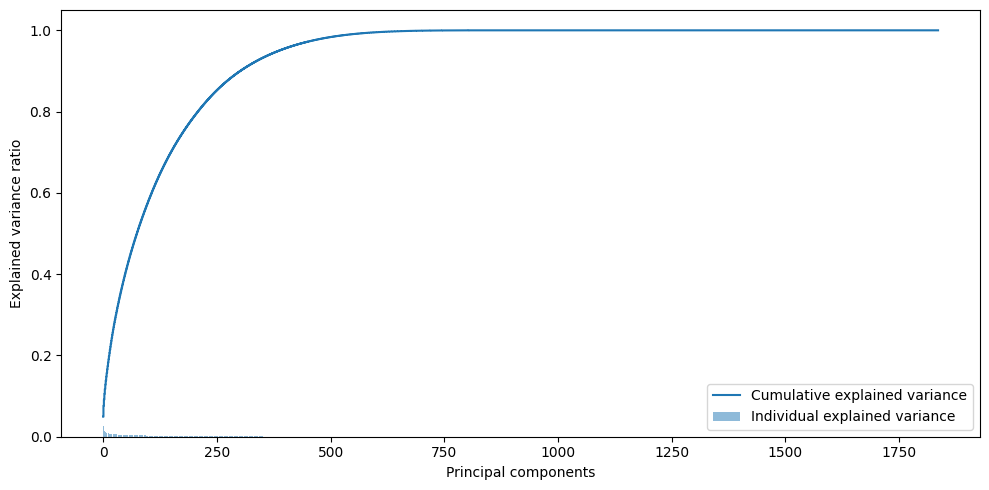

In [114]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

# Plotting individual explained variance
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(len(cumulative_variance)), cumulative_variance, where='mid', label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [115]:
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, len(pca.explained_variance_)+1)])

In [116]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC1828,PC1829,PC1830,PC1831,PC1832,PC1833,PC1834,PC1835,PC1836,PC1837
0,26.006702,-8.500689,-3.433234,-2.844283,-10.866966,3.938278,0.879613,2.753109,-2.687623,-0.125977,...,-6.127030e-18,6.739846e-18,2.269651e-17,2.229406e-17,-1.368758e-17,5.800217e-18,1.244307e-17,-5.385541e-18,7.587325e-18,-3.346669e-18
1,-5.584659,1.164608,1.101619,0.255697,-0.750943,-0.489866,-0.055464,-0.126199,2.444880,-0.295269,...,-5.210803e-16,-2.619519e-16,3.426156e-16,-2.140478e-16,9.562745e-17,-2.215395e-16,-8.625450e-17,-3.672472e-17,3.426983e-17,2.748741e-17
2,-2.838326,0.059257,1.397476,0.516220,0.048517,0.356772,0.498294,-0.227749,-1.210959,-0.158278,...,6.034409e-16,5.684041e-16,-4.575023e-16,-3.841175e-16,-3.691596e-18,3.223599e-16,2.328962e-16,2.640613e-17,-1.123224e-16,-2.539019e-17
3,-5.020120,0.949153,0.862894,0.296127,-0.575863,-0.192792,0.007518,-0.172940,0.848904,-0.025659,...,-1.086952e-17,-6.723919e-16,8.574702e-17,-1.110060e-16,9.088788e-17,1.534380e-16,5.221815e-17,-1.699074e-16,-5.244846e-17,-2.366311e-17
4,-5.429418,1.028143,0.931188,0.294320,-0.978853,-0.293718,-0.067843,-0.273485,2.411778,0.031436,...,-1.334147e-15,2.615092e-16,-1.636029e-16,3.034595e-16,9.234380e-17,3.365915e-17,3.237858e-17,1.689514e-16,-9.622819e-17,-1.931073e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1832,-4.727245,0.815132,0.826794,0.181754,-0.429226,-0.274234,0.218238,-0.234532,0.407390,-0.068561,...,1.099209e-16,2.579168e-16,-2.613978e-16,1.125019e-16,-1.529638e-16,5.539479e-17,-6.776453e-17,5.239813e-17,-4.026310e-17,2.475693e-17
1833,-5.060956,0.971678,0.931234,0.282129,-0.367370,-0.275011,0.003472,-0.066344,1.029553,-0.114166,...,4.233539e-16,-5.349156e-17,4.948910e-16,-4.313882e-16,-2.211386e-16,1.114612e-16,2.987806e-16,-4.742022e-17,2.158308e-16,-3.939805e-17
1834,-2.787436,-0.039599,1.262954,0.211244,-0.318714,-0.132194,-1.179259,0.724823,0.246921,0.954306,...,2.203932e-16,-8.412529e-16,3.555234e-16,-2.586001e-16,2.488860e-16,4.300097e-17,1.374156e-16,1.131152e-16,-7.597200e-17,-9.240958e-17
1835,-4.559121,0.792150,0.855665,0.182094,-0.218717,-0.132231,0.245049,0.018719,0.042894,0.045622,...,-7.671269e-18,-4.477385e-16,3.558144e-16,1.482933e-16,1.919540e-16,-2.421639e-16,2.283804e-18,1.052872e-16,-1.073546e-16,7.673831e-17


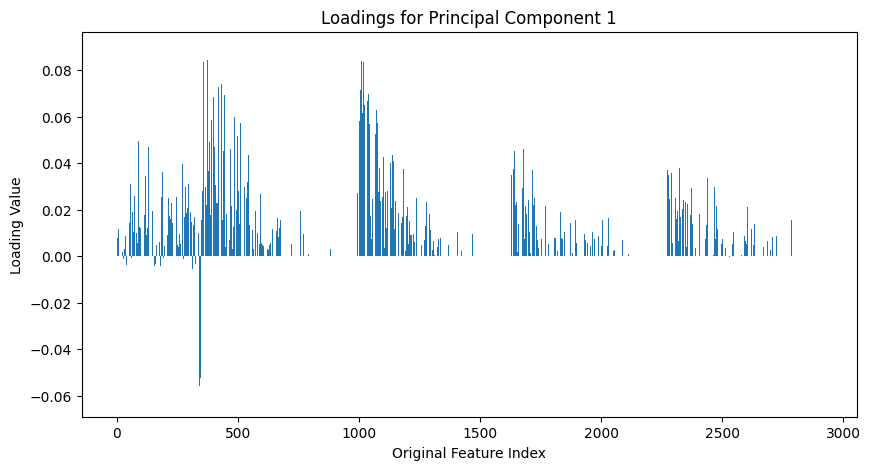

In [117]:
loadings = pca.components_
plt.figure(figsize=(10,5))
plt.bar(range(len(loadings[0])), loadings[0])
plt.xlabel('Original Feature Index')
plt.ylabel('Loading Value')
plt.title('Loadings for Principal Component 1')
plt.show()

# Training

In [118]:
pe_type_mapping = {
    'segmental': 1,
    'central': 1,
    'subsegmental': 1
}

split_label.loc[:, 'pe_type'] = split_label['pe_type'].replace(pe_type_mapping)
split_label['pe_type'].fillna(0, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [119]:
X_train = df_top_features[split_label['split'] == 'train']
y_train = split_label[split_label['split'] == 'train']['pe_type']

X_val = df_top_features[split_label['split'] == 'val']
y_val = split_label[split_label['split'] == 'val']['pe_type']

X_test = df_top_features[split_label['split'] == 'test']
y_test = split_label[split_label['split'] == 'test']['pe_type']

In [120]:
print(X_val.shape)

(193, 1505)


In [121]:
print(X_train.value_counts())

current_age_yrs  Female  Male  Asian  Black  Native American  Other  Pacific Islander  Unknown_race  White  SMOKER_N  SMOKER_Y  OTHER CONDITIONS ORIGINATING IN THE PERINATAL PERIOD:frequency  COMPLICATIONS MAINLY RELATED TO PREGNANCY:frequency   COMPLICATIONS OCCURRING MAINLY IN THE COURSE OF LABOR AND DELIVERY:frequency  COMPLICATIONS OF THE PUERPERIUM:frequency   ECTOPIC AND MOLAR PREGNANCY:frequency  NORMAL DELIVERY, AND OTHER INDICATIONS FOR CARE IN PREGNANCY, LABOR, AND DELIVERY:frequency  OTHER PREGNANCY WITH ABORTIVE OUTCOME:frequency  Anomalies of respiratory system, congenital:frequency   Bulbus cordis anomalies and anomalies of cardiac septal closure:frequency   Chromosomal anomalies:frequency  Congenital anomalies of ear, face, and neck:frequency  Congenital anomalies of eye:frequency   Congenital anomalies of genital organs:frequency  Congenital anomalies of the integument:frequency  Congenital anomalies of urinary system:frequency   Other and unspecified congenital anomali

In [122]:
offending_columns = [col for col in X_train.columns if any(char in col for char in ['[', ']', '<'])]

print(offending_columns)

X_train = X_train.rename(columns={col: col.replace('[', '').replace(']', '').replace('<', '') for col in offending_columns})
X_val = X_val.rename(columns={col: col.replace('[', '').replace(']', '').replace('<', '') for col in offending_columns})


[' HUMAN IMMUNODEFICIENCY VIRUS [HIV] INFECTION:frequency', ' HUMAN IMMUNODEFICIENCY VIRUS [HIV] INFECTION:presence']


In [123]:
import xgboost as xgb

In [124]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

param = {
    'max_depth': 10,
    'eta': 0.05,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'alpha': 0.3,
    'lambda': 1.5,
    'min_child_weight': 20
}

evallist = [(dval, 'eval'), (dtrain, 'train')]
evals_result = {}
num_round = 100
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=5, evals_result=evals_result)


[0]	eval-logloss:0.74365	train-logloss:0.62042


Pass `evals` as keyword args.


[1]	eval-logloss:0.73519	train-logloss:0.61220
[2]	eval-logloss:0.70803	train-logloss:0.58833
[3]	eval-logloss:0.68231	train-logloss:0.56653
[4]	eval-logloss:0.65912	train-logloss:0.54651
[5]	eval-logloss:0.63821	train-logloss:0.52849
[6]	eval-logloss:0.61916	train-logloss:0.51196
[7]	eval-logloss:0.60209	train-logloss:0.49682
[8]	eval-logloss:0.58617	train-logloss:0.48295
[9]	eval-logloss:0.57274	train-logloss:0.47047
[10]	eval-logloss:0.55880	train-logloss:0.45840
[11]	eval-logloss:0.54771	train-logloss:0.44751
[12]	eval-logloss:0.53655	train-logloss:0.43728
[13]	eval-logloss:0.52584	train-logloss:0.42703
[14]	eval-logloss:0.51729	train-logloss:0.41852
[15]	eval-logloss:0.50849	train-logloss:0.41016
[16]	eval-logloss:0.50646	train-logloss:0.40718
[17]	eval-logloss:0.49867	train-logloss:0.39958
[18]	eval-logloss:0.49051	train-logloss:0.39253
[19]	eval-logloss:0.48872	train-logloss:0.38965
[20]	eval-logloss:0.48168	train-logloss:0.38320
[21]	eval-logloss:0.47497	train-logloss:0.37695
[

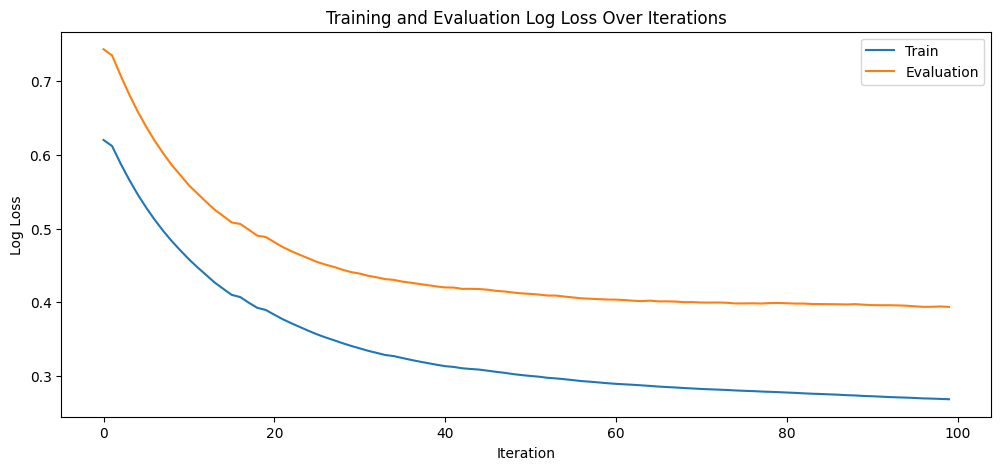

Training Accuracy: 89.06%
Evaluation Accuracy: 87.05%


In [125]:
train_logloss = evals_result['train']['logloss']
eval_logloss = evals_result['eval']['logloss']

plt.figure(figsize=(12, 5))
plt.plot(train_logloss, label='Train')
plt.plot(eval_logloss, label='Evaluation')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Training and Evaluation Log Loss Over Iterations')
plt.legend()
plt.show()

train_preds_prob = bst.predict(dtrain)
eval_preds_prob = bst.predict(dval)

train_preds = [1 if prob > 0.5 else 0 for prob in train_preds_prob]
eval_preds = [1 if prob > 0.5 else 0 for prob in eval_preds_prob]

train_accuracy = np.mean(train_preds == y_train)
eval_accuracy = np.mean(eval_preds == y_val)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Evaluation Accuracy: {eval_accuracy * 100:.2f}%")

# Visualizations

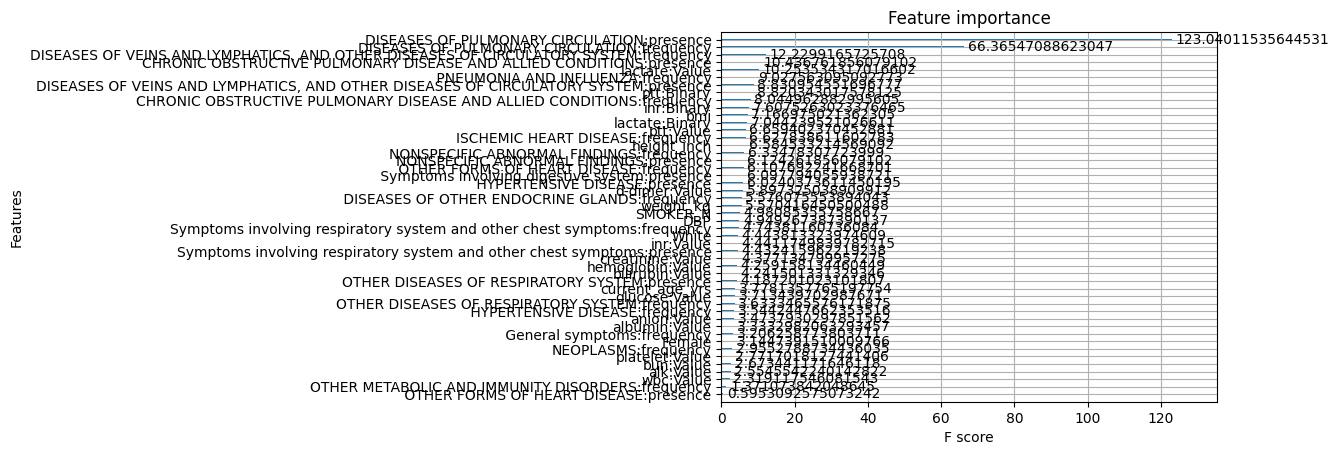

In [126]:
xgb.plot_importance(bst, importance_type='gain')
plt.show()

In [127]:
import shap

explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_train)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

[16:54:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


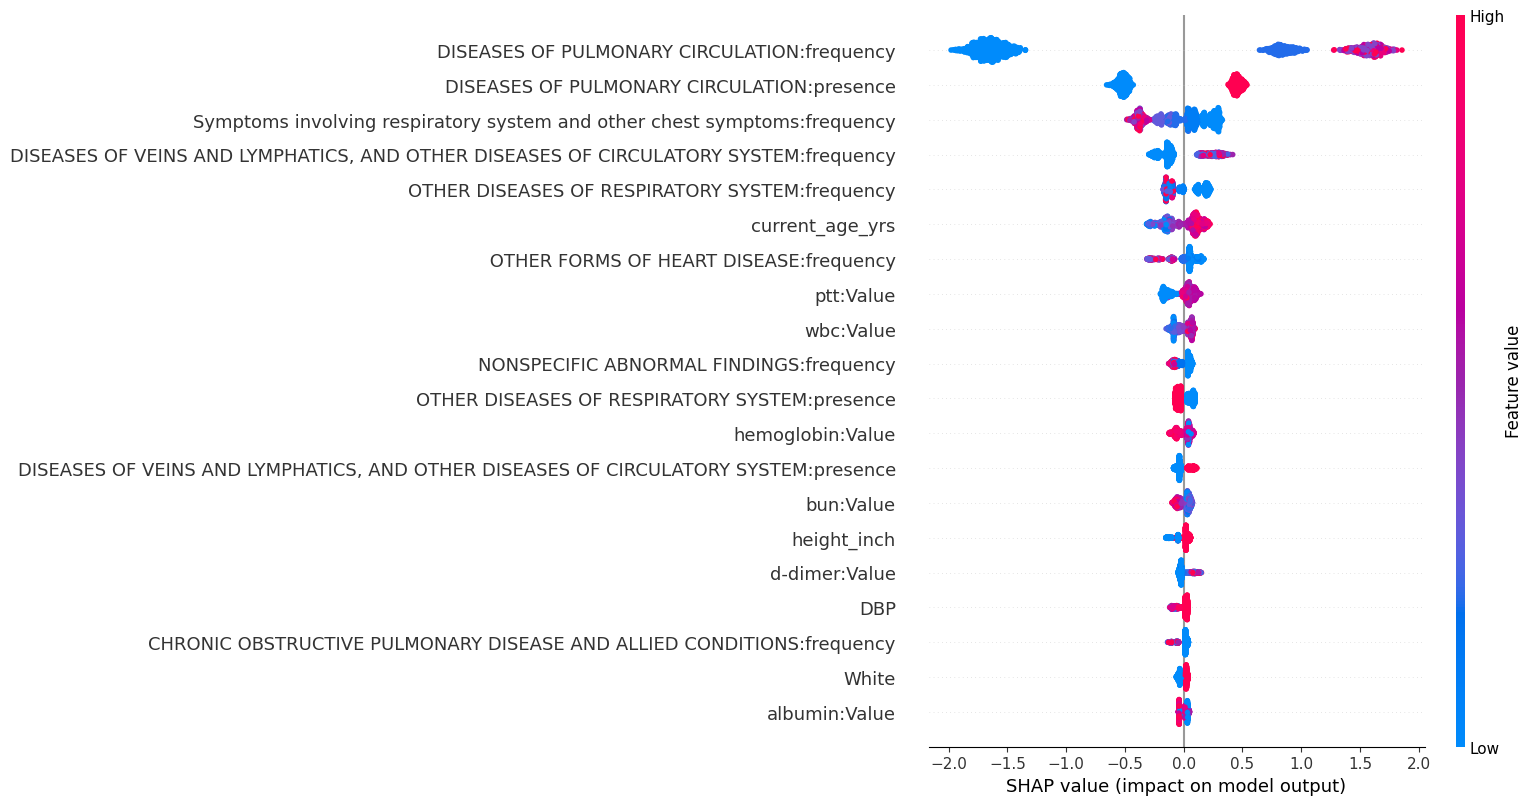

In [128]:
shap.summary_plot(shap_values, X_train)

In [141]:
from xgboost import plot_tree

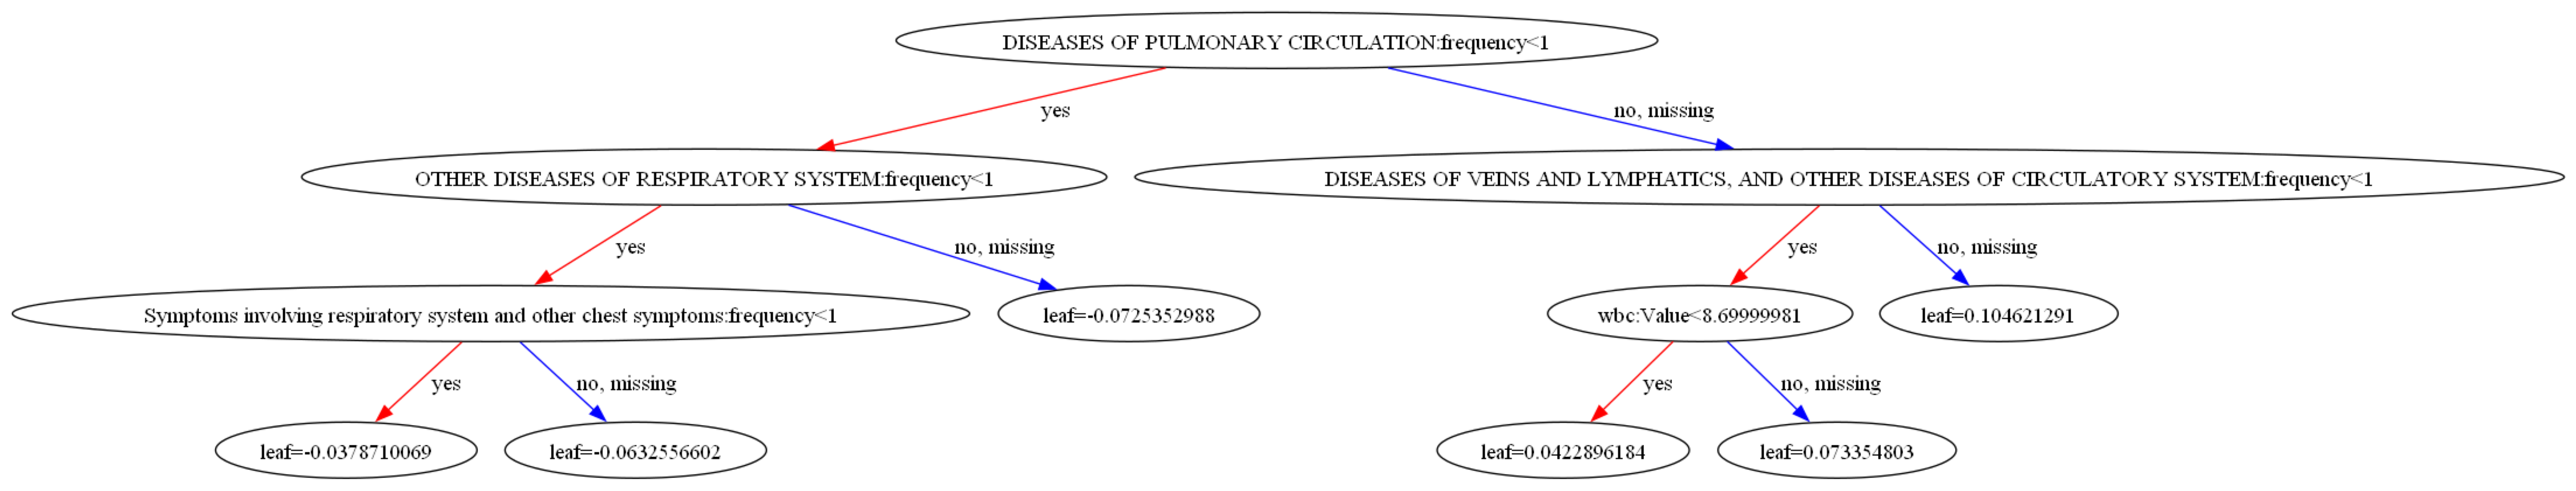

In [144]:
plot_tree(bst)
plt.rcParams['figure.figsize'] = [1000, 10]  # Adjust the size of the plot as needed
plt.show()